# Create the dataset

In [93]:
#External
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, TreebankWordTokenizer, WhitespaceTokenizer
import numpy as np
import pandas as pd
from pprint import pprint
import os
nltk.download('punkt')
from transformers import AutoTokenizer
import textwrap
import re
from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt

#Internal
import data_cleaning.data_cleaning as dc

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arthu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Open Annotated Sentences
We get the sentences from 'prep_data_labeling.ipynb' that we annotated manually with deccano.

In [76]:
annotated_df = pd.read_json('../data/annotated/doccano-extraction-09-12-24.jsonl', lines=True)
annotated_df.head()

,id,text,tagged_entities,document_id,sentence_id,doc__sentence_id,duplicate_ids,label
0,2227,"Conceder à servidora LISIANE RAMOS VILK, ocupa...","[{'entity_group': 'O', 'score': 0.7762932777, ...",25644,2,25644-2,[25644-2],"[[21, 39, PERSON], [62, 88, OCCUPATION], [109,..."
1,2228,MAURÍCIO VIÉGAS DA SILVA Pró-Reitor de Gestão ...,"[{'entity_group': 'PERSON', 'score': 0.6592996...",105798,3,105798-3,"[105798-3, 105799-3, 105801-3, 105802-3, 18001...","[[0, 24, PERSON], [25, 56, OCCUPATION]]"
2,2229,Autorizar o afastamento do país de CRISTINE MA...,"[{'entity_group': 'O', 'score': 0.6819901466, ...",25645,2,25645-2,[25645-2],"[[35, 58, PERSON], [60, 92, OCCUPATION], [170,..."
3,2230,CARLOS ALEXANDRE NETTO Reitor,"[{'entity_group': 'PERSON', 'score': 0.6323550...",25645,4,25645-4,"[25645-4, 25646-4, 25647-4, 25648-4, 25649-4, ...","[[0, 22, PERSON], [23, 29, OCCUPATION]]"
4,2231,Autorizar o afastamento do país de ANDRE DIAS ...,"[{'entity_group': 'O', 'score': 0.6808940768, ...",25646,2,25646-2,[25646-2],"[[35, 53, PERSON], [55, 82, OCCUPATION], [109,..."


### Separate duplicate sentences [OPTIONAL STEP]
(Having repeated sentences might not help training. Ideal solution is using data augmentation if more data is necessary)
Next we'll explode our dataframe so that duplicate sentences can become separate rows. We'll also drop a few columns that will have inconsistent information after the explode and will also not be useful for us.

In [77]:
#annotated_df = annotated_df.explode("duplicate_ids")

### Clean document so only required data is kept
All the document and sentences ids are not needed for training. Their use would be necessary only when trying to map sentences back to the origin.

In [78]:
sentences = annotated_df[['text', 'label']].copy()
print(sentences.shape)
sentences.head() 

(768, 2)


,text,label
0,"Conceder à servidora LISIANE RAMOS VILK, ocupa...","[[21, 39, PERSON], [62, 88, OCCUPATION], [109,..."
1,MAURÍCIO VIÉGAS DA SILVA Pró-Reitor de Gestão ...,"[[0, 24, PERSON], [25, 56, OCCUPATION]]"
2,Autorizar o afastamento do país de CRISTINE MA...,"[[35, 58, PERSON], [60, 92, OCCUPATION], [170,..."
3,CARLOS ALEXANDRE NETTO Reitor,"[[0, 22, PERSON], [23, 29, OCCUPATION]]"
4,Autorizar o afastamento do país de ANDRE DIAS ...,"[[35, 53, PERSON], [55, 82, OCCUPATION], [109,..."


Drop all sentences that only contain 1 or less labels. This is useful so that we don't fine tune our model with sentences that have almost no information about named entities. [Optional]

In [79]:
# Check list of sentences with a specific length
#sentences[sentences['label'].map(len) == 1]

In [80]:
#Drop all sentences that contain 1 or less labels
print('Shape before filter:', sentences.shape)

for idx, row in sentences.iterrows():
    if len(row['label']) <= 1 :
        sentences.drop(idx, inplace=True)
sentences.reset_index(drop=True, inplace=True)

print('Shape after filter:', sentences.shape)

Shape before filter: (768, 2)
Shape after filter: (676, 2)


## Splitting dataset from sentences to list of words

Let's tokenize the sentences and tokens using the TreebankWordTokenizer
The first method 'tokenize' will split our sentence and return a list of words which we'll organize in a 'tokenized_sentences' list.
The second method 'span_tokenize' will return the start and end position of each token resulting from the split. We'll organize them in a 'token_positions' list.

In [81]:
# Split sentences into list of words. 
# Tokenized_sentences is a list of list of words and 
# Token_positions has the start and end position of each word in the original sentence.
tokenized_sentences = []
token_positions = []
for idx, sentence in sentences['text'].items():
    tokenized_sentences.append(TreebankWordTokenizer().tokenize(sentence))
    token_positions.append(list(TreebankWordTokenizer().span_tokenize(sentence)))

#print(tokenized_sentences[0])
#print(token_positions[0])


# We'll zip both the words and their positions together in the same list.
tokenized_sentence_position = []
for sentence, positions in zip(tokenized_sentences, token_positions):
    tokenized_sentence_position.append(list(zip(sentence, positions)))
    
    
# Check the zip
#print(sentences['label'].loc[0])
#tokenized_sentence_position[0]

In [82]:
# Intermediary step to convert the list of words into a dataframe (Used only to facilitate the next steps)
list_of_tokenized_sentences = []
for list_of_words in tokenized_sentence_position:
    tokens_df = pd.DataFrame(list_of_words, columns = ['token', 'pos'])
    tokens_df[['start', 'end']] = tokens_df['pos'].to_list()
    tokens_df = tokens_df.drop(columns='pos')
    list_of_tokenized_sentences.append(tokens_df)

# Check the dataframe
list_of_tokenized_sentences[0]

,token,start,end
0,Conceder,0,8
1,à,9,10
2,servidora,11,20
3,LISIANE,21,28
4,RAMOS,29,34
...,...,...,...
63,o,339,340
64,Processo,341,349
65,nº,350,352
66,23078.015333/2016-19,353,373


### Mapping labels from entities to words
We now have, for each sentences, a dataframe of all the word and a list with all the labels.
What needs to be done is assign the correct label to each word of the tokenized sentence.

In [83]:
for index, token_df in enumerate(list_of_tokenized_sentences):
    labels = []
    is_entity = False
    for idx, token in token_df.iterrows():
        
        for label in sentences['label'].loc[index]:
            
            if token['start'] == label[0]: #Check if the word starts at the same position as the label. (Start is in position 0)
                labels.append('B-' + label[2]) #Puts the label name. (Name is in position 2)
                is_entity = True
                break
            
            if token['start'] >= label[0] and token['end'] <= label[1]: #Check if the word starts after the label and ends before it. (Start is in position 0 and end is in position 1)
                labels.append('I-' + label[2])
                is_entity = True
                break
            
            is_entity = False
            
        if is_entity == False:
            labels.append('O')
            
    token_df['label'] = labels

In [84]:
print(sentences.shape,'\n',
      len(list_of_tokenized_sentences))

(676, 2) 
 676


In [85]:
# Validate that the tokens are correctly assigned to each label.
for index in range(0, 1):
    print('SENTENCE',index, '\n') 
    print(sentences['label'].loc[index], '\n')
    print(list_of_tokenized_sentences[index], '\n')
    #print(list_of_tokenized_sentences[index]['label'].value_counts(), '\n')
list_of_tokenized_sentences[675]
    

SENTENCE 0 

[[21, 39, 'PERSON'], [62, 88, 'OCCUPATION'], [109, 133, 'ORGANIZATION'], [237, 247, 'DATE']] 

                   token  start  end     label
0               Conceder      0    8         O
1                      à      9   10         O
2              servidora     11   20         O
3                LISIANE     21   28  B-PERSON
4                  RAMOS     29   34  I-PERSON
..                   ...    ...  ...       ...
63                     o    339  340         O
64              Processo    341  349         O
65                    nº    350  352         O
66  23078.015333/2016-19    353  373         O
67                     .    373  374         O

[68 rows x 4 columns] 



,token,start,end,label
0,Conceder,0,8,O
1,aposentadoria,9,22,O
2,",",22,23,O
3,nos,24,27,O
4,termos,28,34,O
...,...,...,...,...
144,de,735,737,I-DATE
145,julho,738,743,I-DATE
146,de,744,746,I-DATE
147,1994,747,751,I-DATE


### Visualizing the label distribution

Amount of each label in the dataset:
O                 44826
I-DATE             2842
I-PERSON           2331
B-DATE             1945
I-OCCUPATION       1334
I-ORGANIZATION     1000
B-OCCUPATION        982
B-PERSON            948
B-ORGANIZATION      480
B-LOCATION          153
I-LOCATION           84
Name: count, dtype: int64
bar graph of labels:


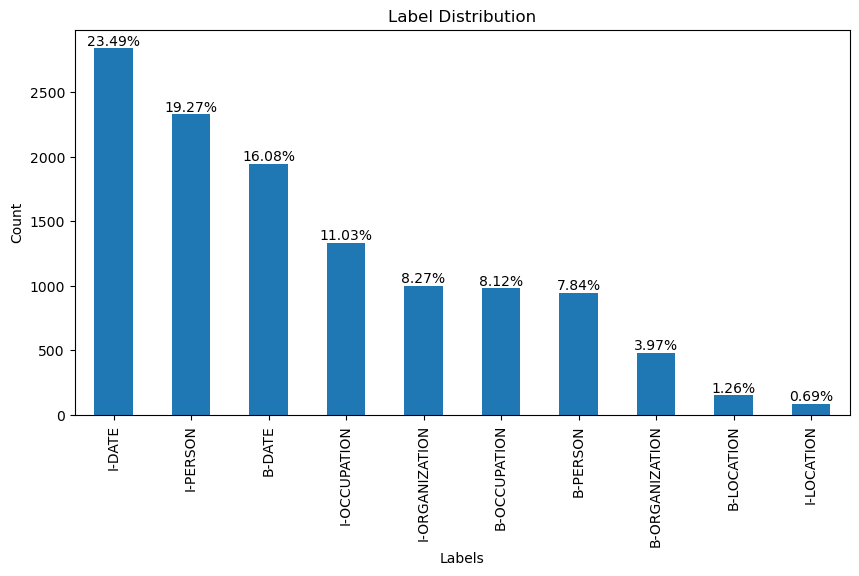

In [86]:
all_labels = []
for token_df in list_of_tokenized_sentences:
    all_labels.extend(token_df['label'].tolist())
labels_series = pd.Series(all_labels)
print("Amount of each label in the dataset:")
print(labels_series.value_counts())
print("bar graph of labels:")
plt.figure(figsize=(10, 5))
labels_series[labels_series != "O"].value_counts().plot(kind='bar', title='Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
# add percentage on top of each bar
for i, v in enumerate(labels_series[labels_series != "O"].value_counts()):
    plt.text(i, v + 0.5, f"{v/labels_series[labels_series != "O"].size*100:.2f}%", ha='center', va='bottom')


In [87]:
target_labels = ['O', 'B-PERSON', 'I-PERSON', 'B-ORGANIZATION', 'I-ORGANIZATION', 'B-LOCATION', 'I-LOCATION', 'B-DATE', 'I-DATE', 'B-OCCUPATION', 'I-OCCUPATION']

# Convert label from name to id
label_to_id = {
    'O': 0, 
    'B-PERSON': 1, 
    'I-PERSON': 2, 
    'B-ORGANIZATION': 3, 
    'I-ORGANIZATION': 4, 
    'B-LOCATION': 5, 
    'I-LOCATION': 6, 
    'B-DATE': 7, 
    'I-DATE': 8,
    'B-OCCUPATION': 9,
    'I-OCCUPATION': 10,
}

id_to_label = {
    0: 'O', 
    1: 'B-PERSON', 
    2: 'I-PERSON', 
    3: 'B-ORGANIZATION', 
    4: 'I-ORGANIZATION', 
    5: 'B-LOCATION', 
    6: 'I-LOCATION', 
    7: 'B-DATE',
    8: 'I-DATE',
    9: 'B-OCCUPATION',
    10: 'I-OCCUPATION'
}
for sentence in list_of_tokenized_sentences:
    sentence['label'] = sentence['label'].map(label_to_id)


In [92]:
list_of_tokenized_sentences[304]

,token,start,end,label
0,Autorizar,0,9,0
1,o,10,11,0
2,afastamento,12,23,0
3,no,24,26,0
4,país,27,31,0
...,...,...,...,...
69,da,408,410,4
70,Defesa.Solicitação,411,429,0
71,n°,430,432,0
72,47046,433,438,0


## Saving the dataset
We will save the final dataset as a HuggingFace Dataset. This will then be imported in the **04_train_token_classifier.ipynb** for usage in training and testing. 
The train/test split will also be done in the following notebook.

In [111]:
# Divide inputs and tokens into X and y lists.
data_X = []
data_y = []
for sentence in list_of_tokenized_sentences:
    data_X.append(list(sentence['token']))
    data_y.append(list(sentence['label']))

# Validate the dimensions of the data
#print(data_X[0])
#print(data_y[0])
print('\nShape of data_X:', len(data_X),
      '\nShape of data_y:', len(data_y))

# Create a dictionary
data_dict = {'tokens': data_X, 'ner_tags': data_y}
ner_dataset = Dataset.from_dict(data_dict)

# Inspect the dataset
print('\n', ner_dataset)


Shape of data_X: 676 
Shape of data_y: 676

 Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 676
})


In [112]:
# Save the dataset to disk
ner_dataset.save_to_disk("../data/annotated/ufrgs_documents_13-06-25")

Saving the dataset (1/1 shards): 100%|██████████| 676/676 [00:00<00:00, 88144.67 examples/s]


# END OF NOTEBOOK
# -------------------------------------------------------------------------------------------------------------------

### All content below is unused (some of it is in the next notebook) or tests
# -------------------------------------------------------------------------------------------------------------------


The format of DatasetDict, which we'll want to use, is a list of three arrow Datasets: train, test and validation. 
Each Dataset is composed of two main object: features and num_rows. We need to make sure our JSON has the features 'tokens' and 'ner_tags'
The sample data uses the following dictionary to convert each label to an int:

**{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}**

Since we are using the exact same labels we can utilize this dictionary as well.

### Splitting dataset into train and test
We'll split our DataFrame into to lists of lists. One for the input tokens and another for the labels.
After that we'll use the scklearn train_test_split method to get both our train and test data.

In [ ]:
def get_label_distribution(seq_labels):
    label_count = {}
    for label in target_labels:
        label_count[label] = 0
    for seq in seq_labels:
        for target_id in seq:
            label = id_to_label[target_id]
            label_count[label] += 1
    return label_count

get_label_distribution(y_train)

get_label_distribution(y_test)

# NOTEBOOK APPENDIX TO TEST TOKENIZATION METHODS

In [19]:
test_sentence = annotated_df['text'][0].lower()
test_sentence

'conceder à servidora lisiane ramos vilk, ocupante do cargo de administrador de edifícios - 701400, lotada na faculdade de arquitetura, siape 2325261, o percentual de 25% (vinte e cinco por cento) de incentivo à qualificação, a contar de 15/07/2016, tendo em vista a conclusão do curso de graduação em administração - bacharelado, conforme o processo nº 23078.015333/2016-19.'

In [20]:
w_tkn = TreebankWordTokenizer().tokenize(test_sentence)

In [21]:
checkpoint = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
sw_tkn_1 = tokenizer(test_sentence, is_split_into_words=False)

checkpoint = 'bert-large-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
sw_tkn_2 = tokenizer(test_sentence, is_split_into_words=False)

checkpoint = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
sw_tkn_3 = tokenizer(test_sentence, is_split_into_words=False)

checkpoint = 'bert-large-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
sw_tkn_4 = tokenizer(test_sentence, is_split_into_words=False)

checkpoint = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
sw_tkn_5 = tokenizer(test_sentence, is_split_into_words=False)

checkpoint = 'bert-large-uncased-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
sw_tkn_6 = tokenizer(test_sentence, is_split_into_words=False)

checkpoint = 'bert-large-cased-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
sw_tkn_7 = tokenizer(test_sentence, is_split_into_words=False)

checkpoint = 'neuralmind/bert-base-portuguese-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
sw_tkn_8 = tokenizer(test_sentence, is_split_into_words=False)

checkpoint = 'neuralmind/bert-large-portuguese-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
sw_tkn_9 = tokenizer(test_sentence, is_split_into_words=False)

In [22]:
print(w_tkn)

['conceder', 'à', 'servidora', 'lisiane', 'ramos', 'vilk', ',', 'ocupante', 'do', 'cargo', 'de', 'administrador', 'de', 'edifícios', '-', '701400', ',', 'lotada', 'na', 'faculdade', 'de', 'arquitetura', ',', 'siape', '2325261', ',', 'o', 'percentual', 'de', '25', '%', '(', 'vinte', 'e', 'cinco', 'por', 'cento', ')', 'de', 'incentivo', 'à', 'qualificação', ',', 'a', 'contar', 'de', '15/07/2016', ',', 'tendo', 'em', 'vista', 'a', 'conclusão', 'do', 'curso', 'de', 'graduação', 'em', 'administração', '-', 'bacharelado', ',', 'conforme', 'o', 'processo', 'nº', '23078.015333/2016-19', '.']


In [23]:
print(sw_tkn_1.tokens())
print(sw_tkn_2.tokens())
print(sw_tkn_3.tokens())
print(sw_tkn_4.tokens())
print(sw_tkn_5.tokens())
print(sw_tkn_6.tokens())
print(sw_tkn_7.tokens())
print(sw_tkn_8.tokens())
print(sw_tkn_9.tokens())

['[CLS]', 'con', '##cede', '##r', 'a', 'ser', '##vid', '##ora', 'li', '##sian', '##e', 'ramos', 'vi', '##lk', ',', 'o', '##cup', '##ante', 'do', 'cargo', 'de', 'ad', '##mini', '##stra', '##dor', 'de', 'ed', '##ific', '##ios', '-', '70', '##14', '##00', ',', 'lot', '##ada', 'na', 'fa', '##cu', '##lda', '##de', 'de', 'ar', '##qui', '##tet', '##ura', ',', 'si', '##ape', '232', '##52', '##6', '##1', ',', 'o', 'percent', '##ual', 'de', '25', '%', '(', 'vin', '##te', 'e', 'ci', '##nco', 'por', 'cent', '##o', ')', 'de', 'inc', '##ent', '##ivo', 'a', 'qu', '##ali', '##fi', '##ca', '##cao', ',', 'a', 'con', '##tar', 'de', '15', '/', '07', '/', '2016', ',', 'tend', '##o', 'em', 'vista', 'a', 'con', '##cl', '##usa', '##o', 'do', 'cu', '##rso', 'de', 'gr', '##ad', '##ua', '##cao', 'em', 'ad', '##mini', '##stra', '##cao', '-', 'bach', '##are', '##lad', '##o', ',', 'conform', '##e', 'o', 'process', '##o', 'n', '##º', '230', '##7', '##8', '.', '01', '##53', '##33', '/', '2016', '-', '19', '.', '[SEP]